In [80]:
#step 1
# basic 2 bit palindrome

In [81]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [82]:
test_string = '11'
binary_string = test_string

In [83]:
is_actually_palindrome = test_string == test_string[::-1]
print(f"Palindrome Check: {'YES' if is_actually_palindrome else 'NO'}")

Palindrome Check: YES


In [84]:
# Create 2 qubits for our string
# Plus 1 qubit to store the comparison result
qubits = QuantumRegister(3, 'q')
bits = ClassicalRegister(3, 'c')
circuit = QuantumCircuit(qubits, bits)

In [85]:
if test_string[0] == '1':
    circuit.x(qubits[0])

if test_string[1] == '1': 
    circuit.x(qubits[1])


In [86]:

circuit.cx(qubits[0], qubits[2])  
circuit.cx(qubits[1], qubits[2]) 

In [87]:
circuit.x(qubits[2])

In [88]:
circuit.measure([0, 1, 2], [0, 1, 2])

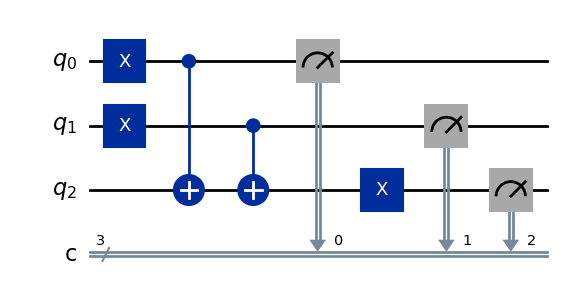

In [89]:
circuit.draw('mpl')

In [90]:
simulator = Aer.get_backend('aer_simulator')
job = simulator.run(circuit, shots=1024)
result = job.result()
counts = result.get_counts()

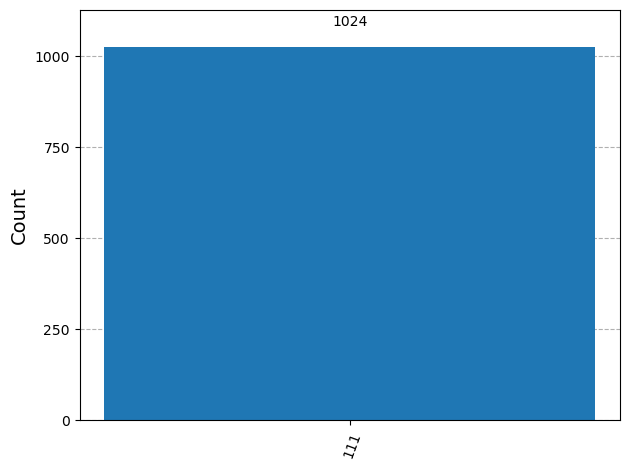

In [91]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

In [92]:
most_common_result = max(counts, key=counts.get)
result_digit = most_common_result[0]
print(f"Quantum result: {'Palindrome' if result_digit == '1' else 'Not palindrome'}")


Quantum result: Palindrome


for 3 qubits we can just compare 1 and 3 qubits and we can solve the problem

similarly,

4 bit string -> compare 1 and 4 , 2 and 3

5 bit string -> compare 1 and 5, 2 and 4

For any N-bit string:

Compare bit 0 with bit N-1
Compare bit 1 with bit N-2
Compare bit 2 with bit N-3
...
Stop when you reach the middle

but so far we are not implementing reversibility right..

In [118]:
while True:
    try:
        binary_string = input("Enter binary string: ").strip()
        
        # Validate input
        if not binary_string:
            print("Please enter something!")
            continue
        
        if not all(c in '01' for c in binary_string):
            print("Only 0s and 1s allowed!")
            continue
        
        if len(binary_string) < 2:
            print("Need at least 2 bits!")
            continue
        
        break
        
    except (KeyboardInterrupt, EOFError):
        print("\nExiting...")
        exit()

In [119]:
# Setup based on string length
string_length = len(binary_string)
num_pairs = string_length // 2

In [120]:
# Create registers dynamically
input_reg = QuantumRegister(string_length, 'input')
comparison_reg = QuantumRegister(num_pairs, 'comp')
result_reg = QuantumRegister(1, 'result')
ancilla_reg = QuantumRegister(num_pairs, 'ancilla')

input_classical = ClassicalRegister(string_length, 'input_meas')
comparison_classical = ClassicalRegister(num_pairs, 'comp_meas')
result_classical = ClassicalRegister(1, 'result_meas')
ancilla_classical = ClassicalRegister(num_pairs, 'ancilla_meas')

In [121]:
# Create circuit
qc = QuantumCircuit(
    input_reg, comparison_reg, result_reg, ancilla_reg,
    input_classical, comparison_classical, result_classical, ancilla_classical
)

In [122]:
# Encode input string
for i, bit in enumerate(binary_string):
    if bit == '1':
        qc.x(input_reg[i])
        print(f"Set input qubit {i} to |1>")

qc.barrier(label='Input Encoded')

Set input qubit 0 to |1>
Set input qubit 2 to |1>
Set input qubit 3 to |1>
Set input qubit 5 to |1>


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=13, num_clbits=0, params=[]), qubits=(<Qubit register=(6, "input"), index=0>, <Qubit register=(6, "input"), index=1>, <Qubit register=(6, "input"), index=2>, <Qubit register=(6, "input"), index=3>, <Qubit register=(6, "input"), index=4>, <Qubit register=(6, "input"), index=5>, <Qubit register=(3, "comp"), index=0>, <Qubit register=(3, "comp"), index=1>, <Qubit register=(3, "comp"), index=2>, <Qubit register=(1, "result"), index=0>, <Qubit register=(3, "ancilla"), index=0>, <Qubit register=(3, "ancilla"), index=1>, <Qubit register=(3, "ancilla"), index=2>), clbits=())

In [123]:
# Compare pairs of bits
for i in range(num_pairs):
    left_bit = i
    right_bit = string_length - 1 - i
    
    print(f"Comparing position {left_bit} with position {right_bit}")
    print(f"  Values: '{binary_string[left_bit]}' vs '{binary_string[right_bit]}'")
    
    # Use ancilla qubit to compute XOR of the pair
    qc.cx(input_reg[left_bit], ancilla_reg[i])
    qc.cx(input_reg[right_bit], ancilla_reg[i])
    
    # Store comparison result (inverted: 0 = different, 1 = same)
    qc.x(ancilla_reg[i])  # Invert so 1 means "same"
    qc.cx(ancilla_reg[i], comparison_reg[i])
    qc.x(ancilla_reg[i])  # Invert back

qc.barrier(label='Comparisons Done')


Comparing position 0 with position 5
  Values: '1' vs '1'
Comparing position 1 with position 4
  Values: '0' vs '0'
Comparing position 2 with position 3
  Values: '1' vs '1'


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=13, num_clbits=0, params=[]), qubits=(<Qubit register=(6, "input"), index=0>, <Qubit register=(6, "input"), index=1>, <Qubit register=(6, "input"), index=2>, <Qubit register=(6, "input"), index=3>, <Qubit register=(6, "input"), index=4>, <Qubit register=(6, "input"), index=5>, <Qubit register=(3, "comp"), index=0>, <Qubit register=(3, "comp"), index=1>, <Qubit register=(3, "comp"), index=2>, <Qubit register=(1, "result"), index=0>, <Qubit register=(3, "ancilla"), index=0>, <Qubit register=(3, "ancilla"), index=1>, <Qubit register=(3, "ancilla"), index=2>), clbits=())

In [124]:
print("\n=== STEP 3: COMBINE RESULTS ===")
# Combine all comparison results
if num_pairs == 1:
    print("Single pair: copying comparison to result")
    qc.cx(comparison_reg[0], result_reg[0])
elif num_pairs == 2:
    print("Two pairs: using Toffoli for AND")
    qc.ccx(comparison_reg[0], comparison_reg[1], result_reg[0])
else:
    print(f"Multiple pairs: using simplified AND logic")
    qc.cx(comparison_reg[0], result_reg[0])

qc.barrier(label='Result Computed')


=== STEP 3: COMBINE RESULTS ===
Multiple pairs: using simplified AND logic


CircuitInstruction(operation=Instruction(name='barrier', num_qubits=13, num_clbits=0, params=[]), qubits=(<Qubit register=(6, "input"), index=0>, <Qubit register=(6, "input"), index=1>, <Qubit register=(6, "input"), index=2>, <Qubit register=(6, "input"), index=3>, <Qubit register=(6, "input"), index=4>, <Qubit register=(6, "input"), index=5>, <Qubit register=(3, "comp"), index=0>, <Qubit register=(3, "comp"), index=1>, <Qubit register=(3, "comp"), index=2>, <Qubit register=(1, "result"), index=0>, <Qubit register=(3, "ancilla"), index=0>, <Qubit register=(3, "ancilla"), index=1>, <Qubit register=(3, "ancilla"), index=2>), clbits=())

In [125]:
# Measure everything
qc.measure(input_reg, input_classical)
qc.measure(comparison_reg, comparison_classical)
qc.measure(result_reg, result_classical)
qc.measure(ancilla_reg, ancilla_classical)

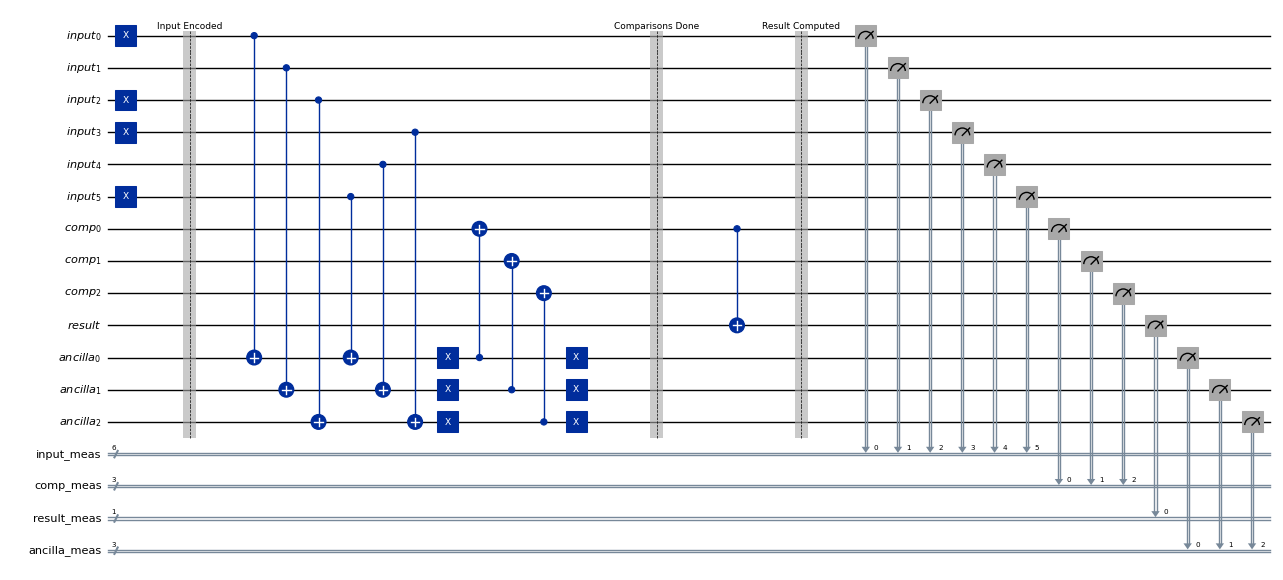

In [126]:
qc.draw('mpl', scale=0.5, fold=-1)

In [131]:
# Simulate
simulator = AerSimulator()
job = simulator.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'000 1 111 101101': 1000}

In [130]:
# Get most frequent result
most_common_bitstring = max(counts, key=counts.get)
most_common_bitstring

'000 1 111 101101'

In [132]:
# Parse the result
bits = most_common_bitstring.split()
if len(bits) == 4:
    ancilla_bits = bits[0]
    result_bits = bits[1]
    comp_bits = bits[2]
    input_bits = bits[3]
    
    measured_input = input_bits
    measured_comparisons = comp_bits
    measured_result = int(result_bits, 2) if result_bits else 0
    measured_ancilla = int(ancilla_bits, 2) if ancilla_bits else 0
    
    print(f"    Recovered input: '{measured_input}'")
    print(f"    Comparisons: '{measured_comparisons}'")
    print(f"    Palindrome result: {'YES' if measured_result else 'NO'}")
    print(f"    Ancilla: {measured_ancilla}")


    Recovered input: '101101'
    Comparisons: '111'
    Palindrome result: YES
    Ancilla: 0


In [133]:
# Check if correct
is_actually_palindrome = binary_string == binary_string[::-1]
print(f"\nExpected: {'Palindrome' if is_actually_palindrome else 'Not Palindrome'}")

if measured_result == (1 if is_actually_palindrome else 0):
    print("✓ CORRECT RESULT!")
else:
    print("✗ Error detected")



Expected: Palindrome
✓ CORRECT RESULT!


In [134]:
# Create reversibility demo circuit
qc_rev = QuantumCircuit(
    input_reg, comparison_reg, result_reg, ancilla_reg,
    input_classical, comparison_classical, result_classical, ancilla_classical
)

# Step 1: Encode input
for i, bit in enumerate(binary_string):
    if bit == '1':
        qc_rev.x(input_reg[i])

qc_rev.barrier(label='Input Encoded')

# Step 2: Forward computation
for i in range(num_pairs):
    left_bit = i
    right_bit = string_length - 1 - i
    
    qc_rev.cx(input_reg[left_bit], ancilla_reg[i])
    qc_rev.cx(input_reg[right_bit], ancilla_reg[i])
    qc_rev.x(ancilla_reg[i])
    qc_rev.cx(ancilla_reg[i], comparison_reg[i])
    qc_rev.x(ancilla_reg[i])

# Combine results
if num_pairs == 1:
    qc_rev.cx(comparison_reg[0], result_reg[0])
elif num_pairs == 2:
    qc_rev.ccx(comparison_reg[0], comparison_reg[1], result_reg[0])
else:
    qc_rev.cx(comparison_reg[0], result_reg[0])

qc_rev.barrier(label='Forward Done')

# Step 3: REVERSE the computation
print("Reversing the computation...")

# Reverse result combination
if num_pairs == 1:
    qc_rev.cx(comparison_reg[0], result_reg[0])
elif num_pairs == 2:
    qc_rev.ccx(comparison_reg[0], comparison_reg[1], result_reg[0])
else:
    qc_rev.cx(comparison_reg[0], result_reg[0])

# Reverse pair comparisons
for i in reversed(range(num_pairs)):
    left_bit = i
    right_bit = string_length - 1 - i
    
    qc_rev.x(ancilla_reg[i])
    qc_rev.cx(ancilla_reg[i], comparison_reg[i])
    qc_rev.x(ancilla_reg[i])
    qc_rev.cx(input_reg[right_bit], ancilla_reg[i])
    qc_rev.cx(input_reg[left_bit], ancilla_reg[i])

qc_rev.barrier(label='Computation Reversed')

# Step 4: Measure to verify recovery
qc_rev.measure(input_reg, input_classical)
qc_rev.measure(comparison_reg, comparison_classical)
qc_rev.measure(result_reg, result_classical)
qc_rev.measure(ancilla_reg, ancilla_classical)

Reversing the computation...


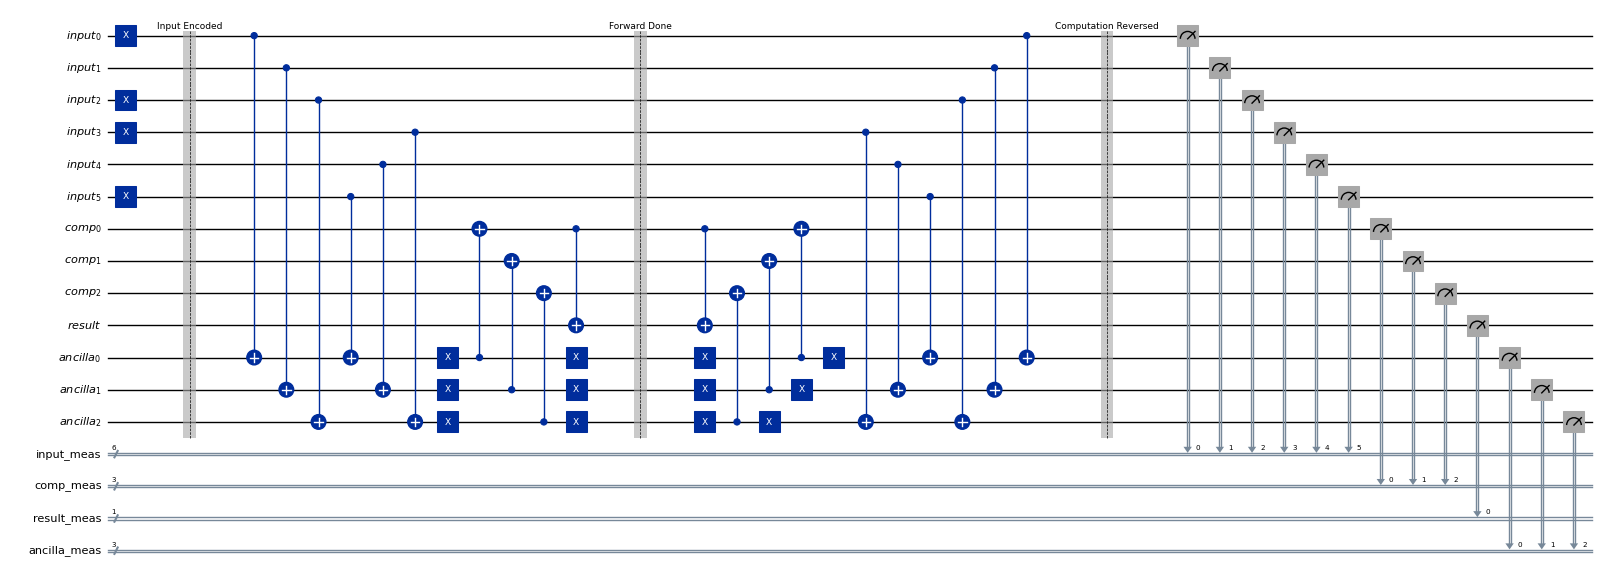

In [135]:
qc_rev.draw('mpl', scale=0.5, fold=-1)

In [137]:
job_rev = simulator.run(qc_rev, shots=1000)
result_rev = job_rev.result()
counts_rev = result_rev.get_counts()

# Get most frequent result
most_common_rev = max(counts_rev, key=counts_rev.get)
most_common_rev

'000 0 000 101101'